In [20]:
%matplotlib inline
import os
import sys
import random
import warnings

import numpy as np

import matplotlib.pyplot as plt

from itertools import chain

from skimage import filters,exposure,segmentation,color,io,img_as_float
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.future import graph
from skimage.transform import resize
from skimage.morphology import label,disk
 

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from keras.optimizers import *

import tensorflow as tf

from sklearn.metrics import f1_score


In [21]:
IMG_HEIGHT = 400
IMG_WIDTH = 400
IMG_CHANNELS = 3

In [22]:
# Helper functions

def load_image(infilename):
    data = imread(infilename)[:,:,:IMG_CHANNELS]
    return data

def load_image_label(infilename):
    data = imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [23]:
# Loaded a set of images
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(400, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image_label(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


In [24]:
print(type(imgs[0]))
print(imgs[0].shape)
print(imgs[0].dtype)

<class 'numpy.ndarray'>
(400, 400, 3)
uint8


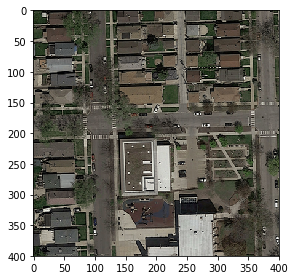

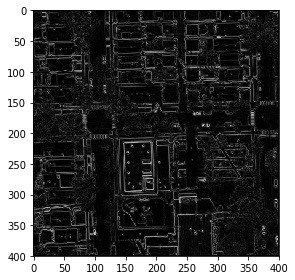

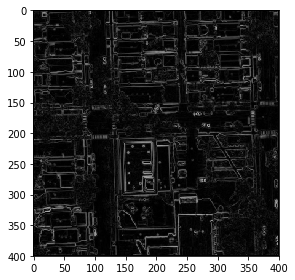

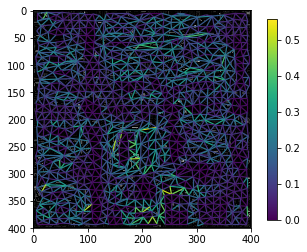

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


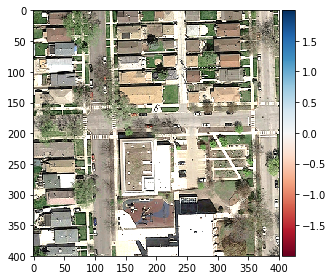

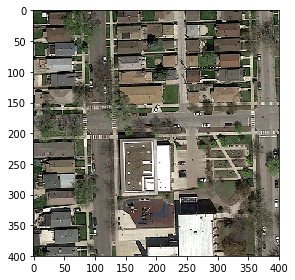

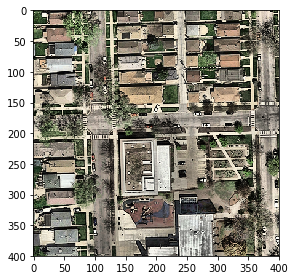

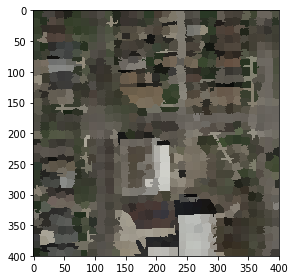

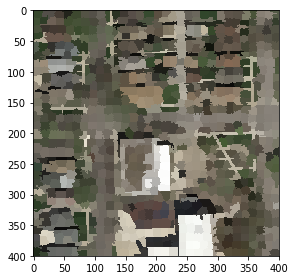

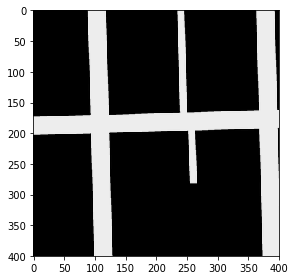

In [35]:
img_idx = 1
img     = imgs[img_idx]
gt_img  = gt_imgs[img_idx]

imshow(img)
plt.show()


#Unsharp mask
unsharp_strength = 0.01
blur_size = 4  # Standard deviation in pixels.
# Convert to float so that negatives don't cause problems
blurred = filters.gaussian(img,blur_size,multichannel=True )
highpass = image - unsharp_strength * blurred
sharp = image + highpass
img_unsharp = sharp


# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Sobel
gimg = color.rgb2gray(img)
edge_roberts = filters.roberts(gimg)
edge_sobel = filters.sobel(gimg)

imshow(edge_roberts)
plt.show()

imshow(edge_sobel)
plt.show()

# K-means
labels_kmeans = segmentation.slic(img, compactness=40, n_segments=1000)
img_kmeans = color.label2rgb(labels_kmeans, img, kind='avg')

# K-means with constrast streching
labels_kmeans = segmentation.slic(img_rescale, compactness=40, n_segments=1000)
img_ckmeans = color.label2rgb(labels_kmeans, img_rescale, kind='avg')


gimg = color.rgb2gray(img)
labels = segmentation.slic(img, compactness=20, n_segments=1000)
edges = filters.sobel(gimg)
edges_rgb = color.gray2rgb(edges)

g = graph.rag_boundary(labels, edges)
lc = graph.show_rag(labels, g, edges_rgb, img_cmap=None, edge_cmap='viridis',
                    edge_width=1.2)

plt.colorbar(lc, fraction=0.03)
plt.show()

imshow(img_unsharp)
plt.show()

imshow(img_rescale)
plt.show()

imshow(img_adapteq)
plt.show()

imshow(img_kmeans)
plt.show()

imshow(img_ckmeans)
plt.show()

imshow(gt_img)
plt.show()

In [26]:
imgs[0].shape

(400, 400, 3)

In [74]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [75]:
type(imgs[0])

numpy.ndarray

In [76]:
# Make data augmentation
# Parameters
batc_size = 2
val_split = 0.1

In [77]:
# Data format
X_train = np.array(imgs)
Y_train = np.zeros((len(imgs), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for i in range(len(imgs)):
    mask_ = np.expand_dims(gt_imgs[i], axis=-1)
    Y_train[i] = mask_    

In [78]:
X_train.shape

(100, 400, 400, 3)

In [79]:
# Shuffle data
# np.random.shuffle(X_train)
# np.random.shuffle(Y_train)
idx_x = int(X_train.shape[0]*(1.0-val_split))
idx_y = int(Y_train.shape[0]*(1.0-val_split))
X_TR  = X_train[:idx_x]
Y_TR  = Y_train[:idx_y]
X_VAL = X_train[idx_x:]
Y_VAL = Y_train[idx_y:]

In [80]:
datagen_dict = dict(featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=90,
    vertical_flip=True,
    horizontal_flip=True,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,                
    fill_mode='reflect',
    dtype=np.uint8)

datagenx_tr = ImageDataGenerator(
**datagen_dict)

datageny_tr = ImageDataGenerator(
    **datagen_dict)

datagenx_val = ImageDataGenerator(
    **datagen_dict)

datageny_val = ImageDataGenerator(
    **datagen_dict)

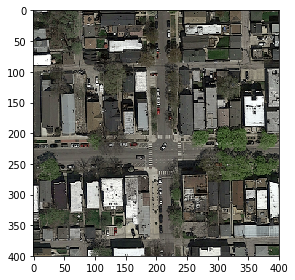

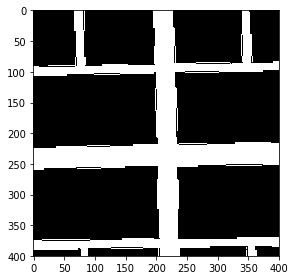

In [81]:
# Check if training data looks all right
ix = random.randint(0, len(imgs) - 1)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [82]:
print(X_train.shape)
print(Y_train.shape)
print(X_train.dtype)
print(Y_train.dtype)

(100, 400, 400, 3)
(100, 400, 400, 1)
uint8
bool
